In [1]:
import matplotlib.pyplot as plt
import torch
from soft_gp_deriv import SoftGPDeriv
from train_deriv import SineDataset, my_collate_fn
from gp.util import flatten_dataset
from torch.utils.data import random_split, DataLoader, Dataset, Subset

from itertools import product
from functools import partial
from torch.autograd.functional import jacobian
from gp.soft_gp.mll import HutchinsonPseudoLoss

torch.manual_seed(42)


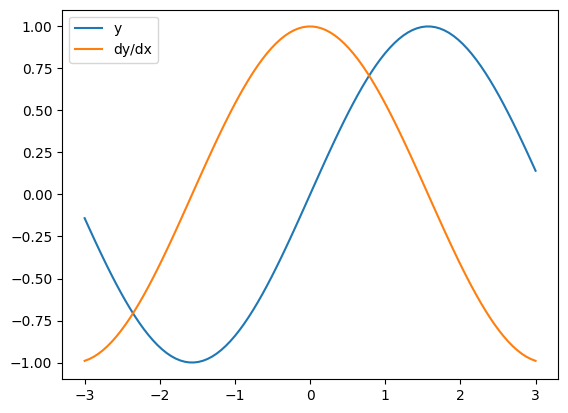

In [2]:
dataset = SineDataset()
batch_size = 40
dataloader = DataLoader(dataset, collate_fn=my_collate_fn, batch_size=batch_size, shuffle=False)
xs = []
ys = []
ys_deriv = []
for batch_x, batch_y in dataloader:
    b = len(batch_x)
    xs += [batch_x]
    ys += [batch_y[:b]]
    ys_deriv += [batch_y[b:]]
plt.plot(torch.cat(xs), torch.cat(ys), label="y")
plt.plot(torch.cat(xs), torch.cat(ys_deriv), label="dy/dx")
plt.legend()

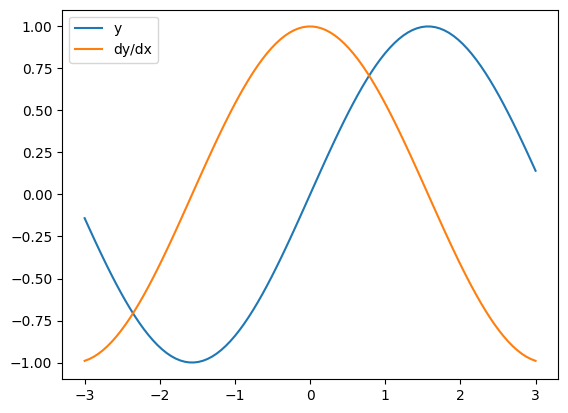

In [3]:
dataset = SineDataset()
xs2 = []; ys2 = []; ys_deriv2 = []
for x, y in dataset:
    xs2 += [x]
    ys2 += [y["energy"]]
    ys_deriv2 += [y["neg_force"].flatten()]
plt.plot(torch.cat(xs2), torch.cat(ys2), label="y")
plt.plot(torch.cat(xs2), torch.cat(ys_deriv2), label="dy/dx")
plt.legend()

In [4]:
torch.allclose(torch.cat(ys_deriv), torch.cat(ys_deriv2))

True

In [5]:
from gpytorch.kernels import ScaleKernel, RBFKernel

kernel = RBFKernel()
inducing_points = torch.linspace(-2.9, 2.9, 40).unsqueeze(1)
# inducing_points = torch.tensor([
#     [-2.9],
#     [-2],
#     [-0.5],
#     [0.1],
#     [0.5],
#     [2],
#     [2.9]
# ])
softgp = SoftGPDeriv(
    kernel,
    inducing_points,
    noise=1e-3,
    learn_noise=False,
    use_scale=False,
    device="cpu",
    dtype=torch.float32,
    solver="solve",
    max_cg_iter=50,
    cg_tolerance=0.5,
    mll_approx="hutchinson",
    fit_chunk_size=1024,
    use_qr=True
)

In [6]:
# X = torch.tensor([
#     [0.0],
#     [0.5]
# ])
X = torch.linspace(-3, 3, 20).unsqueeze(1)
y = torch.sin(X).flatten()
dy = torch.cos(X).flatten()
y = torch.cat([y, dy])
print(y)
K_zz = softgp._mk_cov(softgp.inducing_points)
print(K_zz)
W_xz = softgp._interp(X)
W_xz

tensor([-0.1411, -0.4416, -0.6984, -0.8861, -0.9862, -0.9888, -0.8936, -0.7100,
        -0.4562, -0.1572,  0.1572,  0.4562,  0.7100,  0.8936,  0.9888,  0.9862,
         0.8861,  0.6984,  0.4416,  0.1411, -0.9900, -0.8972, -0.7157, -0.4634,
        -0.1653,  0.1492,  0.4489,  0.7042,  0.8899,  0.9876,  0.9876,  0.8899,
         0.7042,  0.4489,  0.1492, -0.1653, -0.4634, -0.7157, -0.8972, -0.9900])
tensor([[1.0000e+00, 9.7725e-01, 9.1204e-01,  ..., 2.0670e-14, 3.6783e-15,
         6.2509e-16],
        [9.7725e-01, 1.0000e+00, 9.7725e-01,  ..., 1.1093e-13, 2.0670e-14,
         3.6783e-15],
        [9.1204e-01, 9.7725e-01, 1.0000e+00,  ..., 5.6858e-13, 1.1093e-13,
         2.0670e-14],
        ...,
        [2.0670e-14, 1.1093e-13, 5.6858e-13,  ..., 1.0000e+00, 9.7725e-01,
         9.1204e-01],
        [3.6783e-15, 2.0670e-14, 1.1093e-13,  ..., 9.7725e-01, 1.0000e+00,
         9.7725e-01],
        [6.2509e-16, 3.6783e-15, 2.0670e-14,  ..., 9.1204e-01, 9.7725e-01,
         1.0000e+00]], gra

tensor([[ 0.1385,  0.1194,  0.1029,  ...,  0.0006,  0.0005,  0.0004],
        [ 0.0961,  0.1115,  0.1099,  ...,  0.0006,  0.0005,  0.0004],
        [ 0.0603,  0.0700,  0.0812,  ...,  0.0007,  0.0006,  0.0005],
        ...,
        [-0.0005, -0.0006, -0.0007,  ...,  0.0746,  0.0651,  0.0567],
        [-0.0004, -0.0005, -0.0006,  ..., -0.0978,  0.0991,  0.0869],
        [-0.0004, -0.0005, -0.0006,  ..., -0.0923, -0.1051, -0.1194]],
       grad_fn=<CatBackward0>)

In [7]:
def f(x, z):
    distances = torch.zeros(len(z))
    for i in range(len(z)):
        distances[i] = torch.linalg.vector_norm(x - z[i], ord=2, dim=0)
    return torch.softmax(-distances, dim=-1)

torch.cat([
    f(X[0], inducing_points).unsqueeze(0),
    f(X[1], inducing_points).unsqueeze(0),
    jacobian(partial(f, X[0]), inducing_points).diagonal(dim1=0, dim2=1),
    jacobian(partial(f, X[1]), inducing_points).diagonal(dim1=0, dim2=1),
], dim=0)

tensor([[ 0.1385,  0.1194,  0.1029,  0.0887,  0.0764,  0.0659,  0.0568,  0.0489,
          0.0422,  0.0363,  0.0313,  0.0270,  0.0233,  0.0200,  0.0173,  0.0149,
          0.0128,  0.0111,  0.0095,  0.0082,  0.0071,  0.0061,  0.0053,  0.0045,
          0.0039,  0.0034,  0.0029,  0.0025,  0.0022,  0.0019,  0.0016,  0.0014,
          0.0012,  0.0010,  0.0009,  0.0008,  0.0007,  0.0006,  0.0005,  0.0004],
        [ 0.0961,  0.1115,  0.1099,  0.0947,  0.0816,  0.0703,  0.0606,  0.0522,
          0.0450,  0.0388,  0.0334,  0.0288,  0.0248,  0.0214,  0.0184,  0.0159,
          0.0137,  0.0118,  0.0102,  0.0088,  0.0076,  0.0065,  0.0056,  0.0048,
          0.0042,  0.0036,  0.0031,  0.0027,  0.0023,  0.0020,  0.0017,  0.0015,
          0.0013,  0.0011,  0.0009,  0.0008,  0.0007,  0.0006,  0.0005,  0.0004],
        [-0.1194, -0.1051, -0.0923, -0.0808, -0.0706, -0.0615, -0.0535, -0.0465,
         -0.0404, -0.0350, -0.0303, -0.0263, -0.0227, -0.0196, -0.0170, -0.0147,
         -0.0127, -0.0109,

In [8]:
mean = torch.zeros(len(X) * (1 + X.shape[-1]))
cov_mat = W_xz @ K_zz @ W_xz.T 
cov_mat += torch.eye(cov_mat.shape[1]) * 1e-3

print(mean.shape, cov_mat.shape, y.shape)
hutchinson_mll = HutchinsonPseudoLoss(softgp, num_trace_samples=10)
hutchinson_mll(mean, cov_mat, y.reshape(-1))

torch.Size([40]) torch.Size([40, 40]) torch.Size([40])


tensor([12.0626], grad_fn=<DivBackward0>)

In [9]:
N = len(X)
M = len(softgp.inducing_points)
print(N, M)
K_zz = softgp._mk_cov(softgp.inducing_points)
softgp._qr_solve_fit(M, N , X.shape[-1], X, y, K_zz)
softgp.K_zz_alpha

20 40


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


tensor([ 1.0492,  0.5068, -0.0854, -0.6500, -1.1175, -1.4429, -1.6153, -1.6573,
        -1.6155, -1.5437, -1.4853, -1.4610, -1.4645, -1.4690, -1.4387, -1.3424,
        -1.1631, -0.9006, -0.5698, -0.1949,  0.1950,  0.5698,  0.9006,  1.1630,
         1.3424,  1.4387,  1.4689,  1.4644,  1.4609,  1.4854,  1.5438,  1.6155,
         1.6573,  1.6153,  1.4429,  1.1175,  0.6500,  0.0854, -0.5070, -1.0494])

In [10]:
print(softgp.pred(X[0].unsqueeze(0)))
softgp.pred(X)

tensor([-0.5152, -0.5048], grad_fn=<SqueezeBackward1>)


tensor([-0.5152, -0.6126, -0.7949, -0.9266, -0.9686, -0.9338, -0.8385, -0.6794,
        -0.4485, -0.1574,  0.1574,  0.4485,  0.6794,  0.8385,  0.9338,  0.9686,
         0.9266,  0.7949,  0.6126,  0.5151, -0.5048, -0.8683, -0.8057, -0.5321,
        -0.2331,  0.0028,  0.4188,  0.6300,  0.8320,  0.9568,  0.9568,  0.8320,
         0.6300,  0.4188,  0.0028, -0.2331, -0.5321, -0.8057, -0.8683, -0.5048],
       grad_fn=<SqueezeBackward1>)

[-0.5151554  -0.61264247 -0.7948879  -0.9265784  -0.96863925 -0.9337842
 -0.83847934 -0.67942554 -0.4485465  -0.15737051  0.1573678   0.44854012
  0.6794159   0.8384679   0.9337755   0.96863055  0.9265651   0.7948676
  0.6126108   0.5151166 ]
[-0.50480425 -0.8683067  -0.8056783  -0.5320688  -0.23305044  0.00280374
  0.41883868  0.6299749   0.83198375  0.9568003   0.956792    0.83197176
  0.62996745  0.41883573  0.00281302 -0.23305564 -0.53208643 -0.80569136
 -0.8683325  -0.5047704 ]


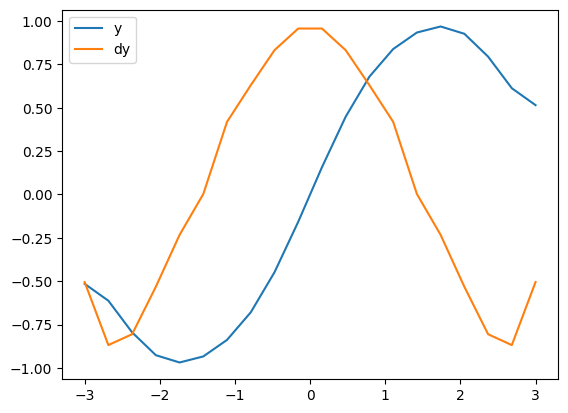

In [11]:
n = 20
test_xs = torch.linspace(-3, 3, n).unsqueeze(-1)
test_ys = softgp.pred(test_xs).detach().numpy()
print(test_ys[:n])
print(test_ys[n:])
plt.plot(test_xs.flatten(), test_ys[:n], label="y")
plt.plot(test_xs.flatten(), test_ys[n:], label="dy")
plt.legend()